In [25]:
import sys
sys.path.insert(0, '../')
from registrationNN.models import model_visualizer
from utils.ObjectUtil import ObjectUtil
import numpy as np
from utils.RegistrationUtils import RegistrationUtils
from utils.ObjectUtil import ObjectUtil
import numpy as np
from lapjv import lapjv
from utils.RegistrationUtils import RegistrationUtils
from sketch_object.UnlabeledObject import UnlabeledObject
import copy
from sketch_object.Stroke import Stroke
from animator.SketchAnimation import SketchAnimation
import pickle5 as pickle
import os

from utils.Config import Config
from utils.ObjectUtil import ObjectUtil
from tools.FeedbackGenerator import VideoGenerator
from registrationNN.models import NNModel
import time
import matplotlib.pyplot as plt
from sketch_object.Point import Point

In [26]:
%load_ext autoreload

%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
model_tag = 'sub_match_exp' # deep learning model to use for alignment
question_name = 'ReflectionQuestion'
org_sketch_id = '2_cd887e29-8029-4b13-bd01-65c78a6b17bf'
tar_sketch_id = '2_b49071f4-14e5-47c9-9d42-c987a07fcec4'

config = Config.default_video_config(question_name, org_sketch_id, tar_sketch_id)
config.vis_video = True
config.load_trans_params = False
config.fine_tune_epochs = 200
config.verbose = 1

model_params = Config.default_model_config(model_tag)
model_params.load = False
model_params.load_ckpt = False
model_params.save = True
model_params.save_ckpt = True
model_params.learning_rate = 5e-4
model_params.epochs = 500
model_params.decay_rate = model_params.learning_rate/model_params.epochs
model_params.batch_size = 32

In [28]:
# load original and target sketch 
org_sketch, org_labels = ObjectUtil.xml_to_UnlabeledObjects(config.org_sketch_path, 
                                                            mn_len=config.mn_len, 
                                                            re_sampling=config.re_sampling, 
                                                            flip=config.org_flip, 
                                                            shift_x=config.org_shift_x,
                                                             shift_y=config.org_shift_y)

tar_sketch, tar_labels = ObjectUtil.xml_to_UnlabeledObjects(config.tar_sketch_path, 
                                                            mn_len=config.mn_len, 
                                                            re_sampling=config.re_sampling, 
                                                            flip=config.tar_flip, 
                                                            shift_x=config.tar_shift_x,
                                                             shift_y=config.tar_shift_y)

In [29]:
tar_labels

['Digit_Word',
 'Two Arrows Horizontal',
 'Rectangle',
 'Parallelogram Right',
 'Digit_Word',
 'Trapezoid Down',
 'Two Arrows Vertical',
 'Digit_Word',
 'Two Arrows Horizontal',
 'Rectangle',
 'Parallelogram Right',
 'Digit_Word',
 'Trapezoid Down',
 'Two Arrows Vertical']

In [30]:
tar_sketch, tar_labels = tar_sketch[:7], tar_labels[:7]

In [31]:
org_labels

['Trapezoid Down',
 'Two Arrows Vertical',
 'Square',
 'Parallelogram Right',
 'Two Arrows Vertical',
 'Trapezoid Down',
 'Two Arrows Vertical',
 'Square',
 'Parallelogram Right',
 'Two Arrows Vertical']

In [32]:
org_sketch, org_labels = org_sketch[:5], org_labels[:5]

<IPython.core.display.Javascript object>


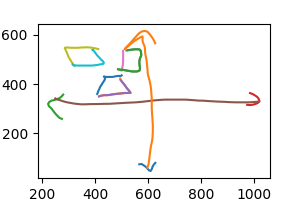

In [33]:
fig, ax = plt.subplots(figsize=(3, 2))
for obj in org_sketch:
    obj.visualize(ax=ax, show=False)

<IPython.core.display.Javascript object>


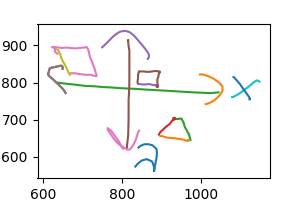

In [34]:
fig, ax = plt.subplots(figsize=(3, 2))
for obj in tar_sketch:
    obj.visualize(ax=ax, show=False)

In [35]:
alignment_model = NNModel(model_params)

In [36]:
# generator = VideoGenerator(alignment_model, config)

In [37]:
# prepare pair-wise set
org_objs, tar_objs = [], []
for obj1 in org_sketch:
    for obj2 in tar_sketch:
        org_objs.append(obj1.get_copy())
        tar_objs.append(obj2.get_copy())

Devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6937989003334919570
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 16477622317375902399
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:1c:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4027113701279916068
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:1d:00.0, compute capability: 7.5"
]
length of original sketchs:35
[models.py] Tue Sep  7 05:44:05 2021: finshed loading the data
Epoch 1/500
2/2 [==============================] - 5s 1s/step - loss: 84.5621 - val_loss: 41.0594

Epoch 00001: loss improved from inf to 83.76465, savi

Epoch 40/500
2/2 [==============================] - 0s 79ms/step - loss: 12.8411 - val_loss: 12.3917

Epoch 00040: loss did not improve from 12.92940
Epoch 41/500
2/2 [==============================] - 0s 80ms/step - loss: 12.5074 - val_loss: 12.0579

Epoch 00041: loss improved from 12.92940 to 12.35313, saving model to ../registrationNN/saved_models/sub_match_exp/cp-best-loss.ckpt
Epoch 42/500
2/2 [==============================] - 0s 88ms/step - loss: 12.0599 - val_loss: 12.2713

Epoch 00042: loss improved from 12.35313 to 12.06236, saving model to ../registrationNN/saved_models/sub_match_exp/cp-best-loss.ckpt
Epoch 43/500
2/2 [==============================] - 0s 79ms/step - loss: 12.3600 - val_loss: 11.7593

Epoch 00043: loss did not improve from 12.06236
Epoch 44/500
2/2 [==============================] - 0s 87ms/step - loss: 11.7868 - val_loss: 11.7675

Epoch 00044: loss improved from 12.06236 to 11.79407, saving model to ../registrationNN/saved_models/sub_match_exp/cp-best-loss.

2/2 [==============================] - 0s 86ms/step - loss: 11.1027 - val_loss: 11.9007

Epoch 00089: loss did not improve from 10.66442
Epoch 90/500
2/2 [==============================] - 0s 260ms/step - loss: 11.8420 - val_loss: 11.0703

Epoch 00090: loss did not improve from 10.66442
Epoch 91/500
2/2 [==============================] - 0s 84ms/step - loss: 11.3156 - val_loss: 11.2743

Epoch 00091: loss did not improve from 10.66442
Epoch 92/500
2/2 [==============================] - 0s 81ms/step - loss: 11.3412 - val_loss: 10.9808

Epoch 00092: loss did not improve from 10.66442
Epoch 93/500
2/2 [==============================] - 0s 88ms/step - loss: 10.9783 - val_loss: 11.2679

Epoch 00093: loss did not improve from 10.66442
Epoch 94/500
2/2 [==============================] - 0s 85ms/step - loss: 11.2088 - val_loss: 10.5282

Epoch 00094: loss did not improve from 10.66442
Epoch 95/500
2/2 [==============================] - 0s 82ms/step - loss: 10.6324 - val_loss: 10.5256

Epoch 0009

2/2 [==============================] - 0s 88ms/step - loss: 10.8414 - val_loss: 10.2486

Epoch 00141: loss did not improve from 9.83617
Epoch 142/500
2/2 [==============================] - 0s 83ms/step - loss: 10.3399 - val_loss: 9.8803

Epoch 00142: loss did not improve from 9.83617
Epoch 143/500
2/2 [==============================] - 0s 81ms/step - loss: 9.9092 - val_loss: 9.8430

Epoch 00143: loss did not improve from 9.83617
Epoch 144/500
2/2 [==============================] - 0s 77ms/step - loss: 9.8882 - val_loss: 10.0998

Epoch 00144: loss did not improve from 9.83617
Epoch 145/500
2/2 [==============================] - 0s 283ms/step - loss: 10.0145 - val_loss: 10.1574

Epoch 00145: loss did not improve from 9.83617
Epoch 146/500
2/2 [==============================] - 0s 81ms/step - loss: 10.2426 - val_loss: 9.9499

Epoch 00146: loss did not improve from 9.83617
Epoch 147/500
2/2 [==============================] - 0s 85ms/step - loss: 9.9998 - val_loss: 10.1557

Epoch 00147: los

2/2 [==============================] - 0s 92ms/step - loss: 10.5761 - val_loss: 9.7792

Epoch 00195: loss did not improve from 9.68639
Epoch 196/500
2/2 [==============================] - 0s 80ms/step - loss: 9.8506 - val_loss: 10.1759

Epoch 00196: loss did not improve from 9.68639
Epoch 197/500
2/2 [==============================] - 0s 83ms/step - loss: 10.1036 - val_loss: 10.0411

Epoch 00197: loss did not improve from 9.68639
Epoch 198/500
2/2 [==============================] - 0s 80ms/step - loss: 10.1581 - val_loss: 10.9743

Epoch 00198: loss did not improve from 9.68639
Epoch 199/500
2/2 [==============================] - 0s 270ms/step - loss: 11.0011 - val_loss: 10.1372

Epoch 00199: loss did not improve from 9.68639
Epoch 200/500
2/2 [==============================] - 0s 84ms/step - loss: 10.2858 - val_loss: 10.3868

Epoch 00200: loss did not improve from 9.68639
Epoch 201/500
2/2 [==============================] - 0s 88ms/step - loss: 10.3607 - val_loss: 10.2108

Epoch 00201:

2/2 [==============================] - 0s 84ms/step - loss: 9.9866 - val_loss: 9.7692

Epoch 00247: loss did not improve from 9.30083
Epoch 248/500
2/2 [==============================] - 0s 80ms/step - loss: 9.8225 - val_loss: 9.5667

Epoch 00248: loss did not improve from 9.30083
Epoch 249/500
2/2 [==============================] - 0s 92ms/step - loss: 9.5617 - val_loss: 9.3334

Epoch 00249: loss did not improve from 9.30083
Epoch 250/500
2/2 [==============================] - 0s 84ms/step - loss: 9.3063 - val_loss: 9.2149

Epoch 00250: loss did not improve from 9.30083
Epoch 251/500
2/2 [==============================] - 0s 83ms/step - loss: 9.1486 - val_loss: 9.1540

Epoch 00251: loss improved from 9.30083 to 9.21608, saving model to ../registrationNN/saved_models/sub_match_exp/cp-best-loss.ckpt
Epoch 252/500
2/2 [==============================] - 0s 92ms/step - loss: 9.1202 - val_loss: 8.9740

Epoch 00252: loss improved from 9.21608 to 9.15781, saving model to ../registrationNN/sav

2/2 [==============================] - 0s 89ms/step - loss: 8.7262 - val_loss: 8.8020

Epoch 00299: loss did not improve from 8.69908
Epoch 300/500
2/2 [==============================] - 0s 88ms/step - loss: 8.8286 - val_loss: 8.7146

Epoch 00300: loss did not improve from 8.69908
Epoch 301/500
2/2 [==============================] - 0s 84ms/step - loss: 8.7122 - val_loss: 8.7250

Epoch 00301: loss did not improve from 8.69908
Epoch 302/500
2/2 [==============================] - 0s 80ms/step - loss: 8.7617 - val_loss: 9.1150

Epoch 00302: loss did not improve from 8.69908
Epoch 303/500
2/2 [==============================] - 0s 91ms/step - loss: 9.1239 - val_loss: 9.2317

Epoch 00303: loss did not improve from 8.69908
Epoch 304/500
2/2 [==============================] - 0s 86ms/step - loss: 9.3161 - val_loss: 9.9895

Epoch 00304: loss did not improve from 8.69908
Epoch 305/500
2/2 [==============================] - 0s 82ms/step - loss: 9.9966 - val_loss: 9.7865

Epoch 00305: loss did not

2/2 [==============================] - 0s 84ms/step - loss: 9.3678 - val_loss: 8.8893

Epoch 00353: loss did not improve from 8.58972
Epoch 354/500
2/2 [==============================] - 0s 82ms/step - loss: 8.8117 - val_loss: 8.8809

Epoch 00354: loss did not improve from 8.58972
Epoch 355/500
2/2 [==============================] - 0s 85ms/step - loss: 8.8684 - val_loss: 9.1269

Epoch 00355: loss did not improve from 8.58972
Epoch 356/500
2/2 [==============================] - 0s 85ms/step - loss: 9.1996 - val_loss: 9.2234

Epoch 00356: loss did not improve from 8.58972
Epoch 357/500
2/2 [==============================] - 0s 86ms/step - loss: 9.2681 - val_loss: 9.4825

Epoch 00357: loss did not improve from 8.58972
Epoch 358/500
2/2 [==============================] - 0s 83ms/step - loss: 9.4404 - val_loss: 9.3405

Epoch 00358: loss did not improve from 8.58972
Epoch 359/500
2/2 [==============================] - 0s 89ms/step - loss: 9.3120 - val_loss: 8.9817

Epoch 00359: loss did not

2/2 [==============================] - 0s 85ms/step - loss: 9.8257 - val_loss: 8.9747

Epoch 00407: loss did not improve from 8.43340
Epoch 408/500
2/2 [==============================] - 0s 80ms/step - loss: 8.9962 - val_loss: 8.8727

Epoch 00408: loss did not improve from 8.43340
Epoch 409/500
2/2 [==============================] - 0s 81ms/step - loss: 8.8545 - val_loss: 8.7918

Epoch 00409: loss did not improve from 8.43340
Epoch 410/500
2/2 [==============================] - 0s 85ms/step - loss: 8.8511 - val_loss: 9.1500

Epoch 00410: loss did not improve from 8.43340
Epoch 411/500
2/2 [==============================] - 0s 87ms/step - loss: 9.1937 - val_loss: 9.2339

Epoch 00411: loss did not improve from 8.43340
Epoch 412/500
2/2 [==============================] - 0s 80ms/step - loss: 9.1894 - val_loss: 9.1987

Epoch 00412: loss did not improve from 8.43340
Epoch 413/500
2/2 [==============================] - 0s 81ms/step - loss: 9.1748 - val_loss: 9.0243

Epoch 00413: loss did not

2/2 [==============================] - 0s 89ms/step - loss: 10.8595 - val_loss: 13.3272

Epoch 00461: loss did not improve from 8.35836
Epoch 462/500
2/2 [==============================] - 0s 83ms/step - loss: 13.2844 - val_loss: 11.5417

Epoch 00462: loss did not improve from 8.35836
Epoch 463/500
2/2 [==============================] - 0s 89ms/step - loss: 11.3836 - val_loss: 13.1224

Epoch 00463: loss did not improve from 8.35836
Epoch 464/500
2/2 [==============================] - 0s 80ms/step - loss: 13.0688 - val_loss: 11.5917

Epoch 00464: loss did not improve from 8.35836
Epoch 465/500
2/2 [==============================] - 0s 85ms/step - loss: 11.7700 - val_loss: 11.7428

Epoch 00465: loss did not improve from 8.35836
Epoch 466/500
2/2 [==============================] - 0s 91ms/step - loss: 11.6579 - val_loss: 11.3892

Epoch 00466: loss did not improve from 8.35836
Epoch 467/500
2/2 [==============================] - 0s 86ms/step - loss: 11.4424 - val_loss: 11.2057

Epoch 00467

<IPython.core.display.Javascript object>


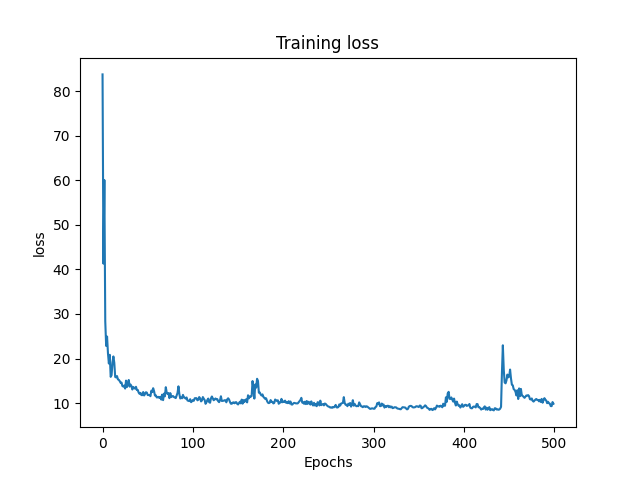

<IPython.core.display.Javascript object>


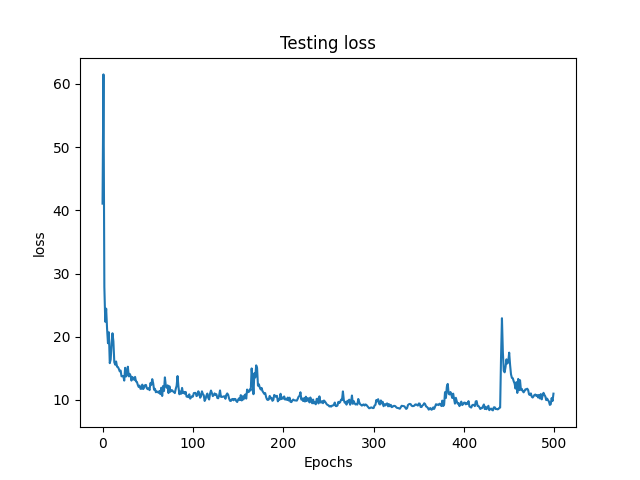

In [38]:
alignment_model.fit(np.array(org_objs), np.array(tar_objs), np.array(org_objs), np.array(tar_objs))

[models.py] visualizing transformation


<IPython.core.display.Javascript object>


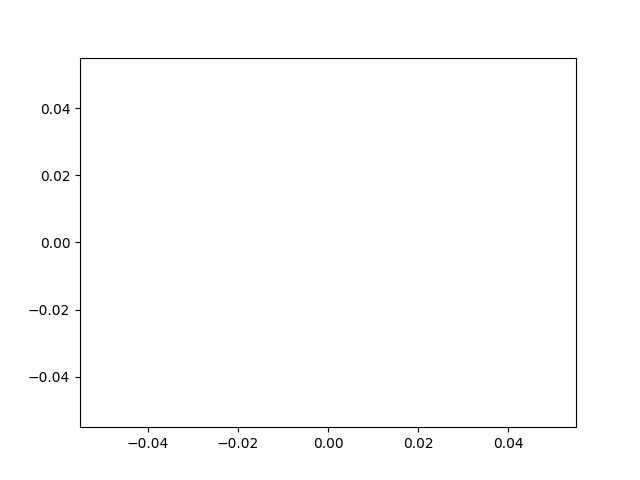

Before [-1.0190685  -0.5889676   3.0805128  -0.01388045  0.48939142 -0.7042258
  2.637964  ]
0.5458813545731479
After [ 5.56290461e-01  3.21506459e-01 -6.10798898e-02  0.00000000e+00
  4.89391443e-01  1.07951211e+03  7.56827584e+02]
Seq Params: [[[0.5562904612033399, 0.0, 0.0, 0.0, 0.3215064591357587, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.4893914434218826, 1.0, 0.0], [0.998135203400126, 0.06104191783839343, 0.0, -0.06104191783839343, 0.998135203400126, 0.0], [1.0, 0.0, 1079.5121116929595, 0.0, 1.0, 756.8275840421304]]]
1 1000


<IPython.core.display.Javascript object>


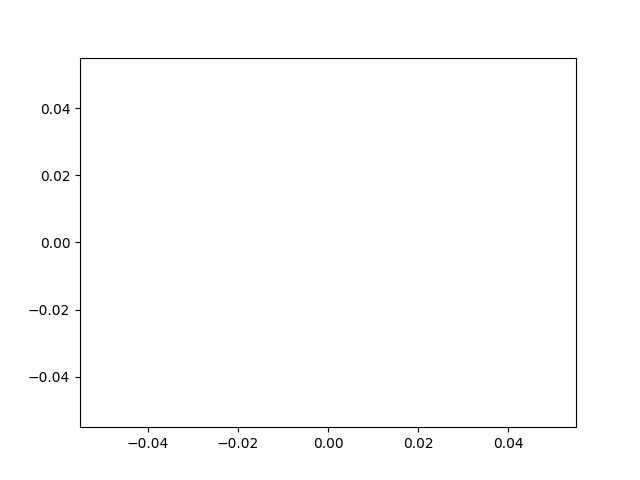

Before [-0.9348315  -0.1714826   2.6544015   0.00492354  0.29390427 -1.0435346
  2.7162685 ]
3.004928299373692
After [ 2.80910158e+00  5.15292900e-01 -4.87191138e-01  0.00000000e+00
  2.93904307e-01  6.07896664e+02  7.54035374e+02]
Seq Params: [[[2.809101578828372, 0.0, 0.0, 0.0, 0.5152928999254025, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.2939043066008988, 1.0, 0.0], [0.8836512995820198, 0.46814568325149336, 0.0, -0.46814568325149336, 0.8836512995820198, 0.0], [1.0, 0.0, 607.8966642855717, 0.0, 1.0, 754.0353737485353]]]
1 1000


<IPython.core.display.Javascript object>

Before [-1.1543124   0.8636748  -1.5427746  -0.21629217 -0.69609267 -1.1192974
 -0.7140488 ]
0.7812743910987117
After [-9.01834746e-01  6.74767045e-01 -1.54277456e+00  0.00000000e+00
 -6.96092647e-01  6.07560971e+02  7.38836158e+02]
Seq Params: [[[-0.9018347464994847, 0.0, 0.0, 0.0, 0.6747670450405897, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, -0.6960926470227232, 1.0, 0.0], [0.02801809997079607, 0.9996074159759053, 0.0, -0.9996074159759053, 0.02801809997079607, 0.0], [1.0, 0.0, 607.5609710417688, 0.0, 1.0, 738.8361580998788]]]
1 1000


<IPython.core.display.Javascript object>

Before [-0.53393584 -2.1041105   2.7906513  -0.10545938  0.5756265   0.14973709
  2.7908912 ]
0.09024145830783319
After [ 4.81831493e-02  1.89877998e-01 -3.50941322e-01  0.00000000e+00
  5.75626465e-01  8.34107811e+02  5.64009442e+02]
Seq Params: [[[0.048183149259509804, 0.0, 0.0, 0.0, 0.18987799801715655, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.5756264646961192, 1.0, 0.0], [0.9390495193997509, 0.3437819077774409, 0.0, -0.3437819077774409, 0.9390495193997509, 0.0], [1.0, 0.0, 834.1078107047081, 0.0, 1.0, 564.0094416427612]]]
1 1000


<IPython.core.display.Javascript object>

Before [-0.95861816 -0.9262327   2.907691    0.02315915  0.06735708 -0.29881936
  2.5526745 ]
0.6303470960692609
After [ 6.04262180e-01  5.83848100e-01 -2.33901644e-01  0.00000000e+00
  6.73570709e-02  8.93760945e+02  6.45042140e+02]
Seq Params: [[[0.6042621802283378, 0.0, 0.0, 0.0, 0.5838480998300593, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.06735707094505489, 1.0, 0.0], [0.9727694990472964, 0.23177467877935234, 0.0, -0.23177467877935234, 0.9727694990472964, 0.0], [1.0, 0.0, 893.7609445095062, 0.0, 1.0, 645.0421396255493]]]
1 1000
[models.py] Tue Sep  7 05:45:16 2021: Saving training visualizations


<IPython.core.display.Javascript object>

0.21864441902617815
3.004928299373692
0.7697788627210104
0.5628463360763282
0.555341957062611


<IPython.core.display.Javascript object>

0.1410609155007601
0.21864441902617815
3.4912154221748204
3.4912154221748204
2.164812904075928


<IPython.core.display.Javascript object>

0.10026828700870354
0.08683245893311162
0.10050590229429157
0.6333333333333333
0.8888888888888888


<IPython.core.display.Javascript object>

0.8409475719637035
0.09024145830783319
0.12695482395068408
0.46984620886999456
0.08683245893311162


<IPython.core.display.Javascript object>

0.6333333333333333
0.5628463360763282
0.12695482395068408
0.1221589249971296
0.08683245893311162
[models.py] Tue Sep  7 05:45:21 2021: Saving training visualizations
[6, 7, 14, 15, 2]


<IPython.core.display.Javascript object>

[18, 5, 22, 24, 6]


<IPython.core.display.Javascript object>

[13, 3, 22, 33, 32]


<IPython.core.display.Javascript object>

[1, 7, 0, 25, 13]


<IPython.core.display.Javascript object>

[20, 7, 20, 26, 23]


<IPython.core.display.Javascript object>

[models.py] Tue Sep  7 05:45:25 2021: Saving training visualizations
[29, 4, 19, 23, 30]


<IPython.core.display.Javascript object>

0.7812743910987117
0.5458813545731479
0.8888888888888888
0.3865646096929928
0.10050590229429157
[1, 33, 9, 28, 12]


<IPython.core.display.Javascript object>

3.4912154221748204
0.1410609155007601
0.07144115449370127
0.12695482395068408
0.10026828700870354
[7, 22, 2, 6, 25]


<IPython.core.display.Javascript object>

0.09024145830783319
3.004928299373692
0.4491223059493483
2.5151442709658647
0.46984620886999456
[9, 24, 13, 29, 9]


<IPython.core.display.Javascript object>

0.07144115449370127
0.8409475719637035
0.40007990708946145
0.7812743910987117
0.07144115449370127
[12, 18, 29, 33, 32]


<IPython.core.display.Javascript object>

0.10026828700870354
0.7697788627210104
0.7812743910987117
0.1410609155007601
0.1221589249971296


In [39]:
model_visualizer.visualize_model(alignment_model, np.array(org_objs), np.array(tar_objs), [], [], model_params)

In [ ]:
n, m = len(org_sketch), len(tar_sketch)

if config.load_trans_params and os.path.exists(os.path.join(config.video_dir, 'transformation_parameters.pkl')):
    with open(os.path.join(config.video_dir, 'transformation_parameters.pkl'), 'rb') as f:
        final_params = pickle.load(f)

    if config.verbose > 2:
        print(f'[VideoGenerator] info: final transformation params: {final_params}')

else:
    # prepare pair-wise set
    org_objs, tar_objs = [], []
    for obj1 in org_sketch:
        for obj2 in tar_sketch:
            org_objs.append(obj1.get_copy())
            tar_objs.append(obj2.get_copy())


    alignment_model.fine_tune(org_objs, tar_objs, 500)

    trans_params, losses = alignment_model.predict(org_objs, tar_objs) # trans_params(N * M, 7)
    trans_params = np.reshape(trans_params, (n, m, 7))
    losses = np.reshape(losses, (n, m))
    
    print(n, m)
    final_params = generator.optimal_transformation(org_sketch, tar_sketch, losses, trans_params) # note: new objects might be added to org_sketch
    if config.verbose > 2:
        print(f'[VideoGenerator] info: pair-wise transformation parameters: {trans_params}')
        print(f'[VideoGenerator] info: pair-wise disimilarity: {losses}')
        print(f'[VideoGenerator] info: final transformation params: {final_params}')

    # save final params in a pickle file 
    with open(os.path.join(config.video_dir, 'transformation_parameters.pkl'), 'wb') as f:
        pickle.dump(final_params, f)

In [79]:
print(f'[VideoGenerator] info: pair-wise disimilarity: {losses}')

[VideoGenerator] info: pair-wise disimilarity: [[13.50888623 10.71565255 10.11698076 15.04417655 11.72813336  6.9405724
  19.27692   ]
 [23.93181922  4.65125994 15.81807254 28.52156938 16.9310583  15.13572575
  26.698503  ]
 [11.67780492 16.50386085  8.41536747 10.32095074 13.60770909  8.55397418
  18.30146339]
 [15.51022357  9.50468483 11.1508655  15.59561838 12.82348153  8.42096758
  22.93337591]
 [21.37010128 36.03258211 22.47787154 16.60930192 15.74422908 24.03243425
   4.67418608]
 [ 3.93579449 25.21500623 15.44355596 11.7691014  11.28702324 12.795604
  19.78837198]
 [14.65510349 15.74913697  5.0977366  12.81900614 11.41436509  8.65140289
  21.66130988]]


In [55]:
if config.load_trans_params and os.path.exists(os.path.join(config.video_dir, 'transformation_parameters.pkl')):
    with open(os.path.join(config.video_dir, 'transformation_parameters.pkl'), 'rb') as f:
        final_params = pickle.load(f)

    if config.verbose > 2:
        print(f'[VideoGenerator] info: final transformation params: {final_params}')

else:   
    print(n, m)
    trans_params, losses = alignment_model.predict(org_objs, tar_objs) # trans_params(N * M, 7)
    trans_params = np.reshape(trans_params, (n, m, 7))
    losses = np.reshape(losses, (n, m))
    final_params = generator.optimal_transformation(org_sketch, tar_sketch, losses, trans_params) # note: new objects might be added to org_sketch
    if config.verbose > 2:
        print(f'[VideoGenerator] info: pair-wise transformation parameters: {trans_params}')
        print(f'[VideoGenerator] info: pair-wise disimilarity: {losses}')
        print(f'[VideoGenerator] info: final transformation params: {final_params}')

    # save final params in a pickle file 
    with open(os.path.join(config.video_dir, 'transformation_parameters.pkl'), 'wb') as f:
        pickle.dump(final_params, f)

5 7


IndexError: index 5 is out of bounds for axis 0 with size 5

In [143]:
org_labels, tar_labels

(['Parallelogram Right', 'Parallelogram Right', 'Parallelogram Right'],
 ['Digit_Word',
  'Two Arrows Vertical',
  'Digit_Word',
  'Square',
  'Trapezoid Down',
  'Two Arrows Horizontal'])

In [144]:
losses

array([[10.60644473,  2.94684925,  8.7032531 ,  8.08387267,  7.15105305,
         4.94085341],
       [11.70429854,  2.52154999, 10.13232374,  4.74191047,  5.69619051,
         1.85075809],
       [11.98865049,  2.49694833,  9.99277552,  5.44880173,  6.07234332,
         1.2334297 ]])

In [107]:
final_params

array([[ 1.00903869e+00,  1.23622215e+00, -1.53108269e-01,
         1.48758292e-03,  8.67656097e-02,  2.22665834e+00,
         1.30540073e-01],
       [ 9.91730809e-01,  6.31879747e-01, -1.26926452e-01,
         6.59403205e-03,  1.00895129e-01,  2.80991745e+00,
         2.23334551e-01],
       [ 1.04797900e+00,  1.28121722e+00, -4.62632999e-02,
         1.43911541e-02,  2.76645988e-01,  2.33903217e+00,
         2.85270333e-01],
       [ 1.00000000e+03,  1.00000000e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.00000000e+03,  1.00000000e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.00000000e+03,  1.00000000e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [108]:
# fix and object in the target objects
cnt_ind = generator.get_widest_obj_ind(tar_sketch)
print(cnt_ind)
# normalize all transformation according to the transformation of the fixed object
a, b = final_params[cnt_ind][5], final_params[cnt_ind][5]
# for i in range(len(final_params)):
#     final_params[i][5] -= a
#     final_params[i][6] -= b

5


<IPython.core.display.Javascript object>


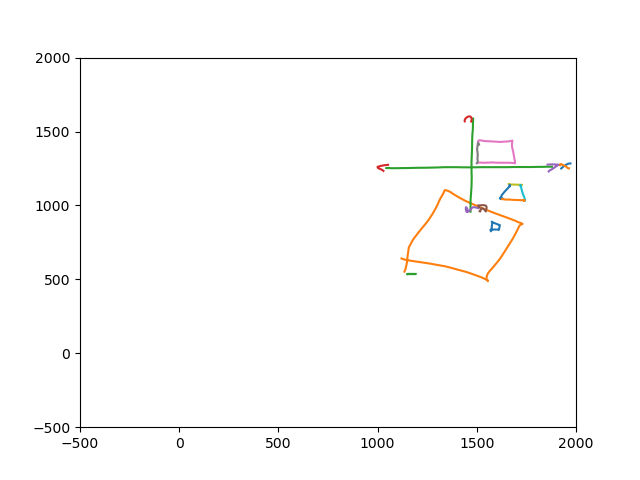

Before [ 1.21320105 -1.28276742  1.59388399 -0.45099983 -0.21058354  0.45765558
  2.83801579]
0.282916179836875
After [-3.43234205e-01  3.62915657e-01 -1.54770866e+00  0.00000000e+00
 -2.10583538e-01  1.61324004e+03  7.94488511e+02]
Before [ 0.90333372 -1.15448368  1.44369197  0.21080658 -0.19171205  1.0926646
  2.54594398]
3.496494539700052
After [-3.15850143e+00  4.03664587e+00 -1.69790068e+00  0.00000000e+00
 -1.91712052e-01  1.13935256e+03  5.15456931e+02]
Before [ 0.03879726 -1.36005318  1.57691169 -0.37473258 -0.28832579  0.16244707
  2.82636786]
0.23872380739739463
After [-9.26182946e-03  3.24677074e-01 -1.56468097e+00  0.00000000e+00
 -2.88325787e-01  1.20042668e+03  5.03503969e+02]
Before [1000. 1000.    0.    0.    0.    0.    0.]
3679.763689398729
After [3.67976369e+06 3.67976369e+06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.19400000e+03 8.28000000e+02]
Before [1000. 1000.    0.    0.    0.    0.    0.]
196.92982960824438
After [196929.82960824 196929.82960824      0. 

In [152]:
# generate the video based on the final params
anim = SketchAnimation(org_sketch, tar_sketch)
anim.seq_animate_all(final_params, save=False, denormalize_trans=True)

In [21]:
# 2, 4, 5
a, b = 2, 2
p, l = alignment_model.predict(org_objs[a:a+1], tar_objs[b:b+1])
p, l = p[0], l[0]
org_obj, tar_obj = org_sketch[a].get_copy(), tar_sketch[b].get_copy()
print(org_labels[a], tar_labels[b])
t = RegistrationUtils.obtain_transformation_matrix(p)
t_denormalized = ObjectUtil.denormalized_transformation(org_obj, tar_obj, t)
org_obj.transform(t_denormalized, object_min_origin=True)
print("loss: ", l)

Square Rectangle
0.6333333333333333
loss:  2.8407993537798


In [22]:
# tot = 0
# for p1 in org_obj.get_points():
#     mn = 1e9
#     for p2 in tar_obj.get_points():
#         mn = min(mn, Point.euclidean_distance(p1, p2))
#     tot += mn

# for p1 in tar_obj.get_points():
#     mn = 1e9
#     for p2 in org_obj.get_points():
#         mn = min(mn, Point.euclidean_distance(p1, p2))
#     tot += mn
# print(tot)

<IPython.core.display.Javascript object>


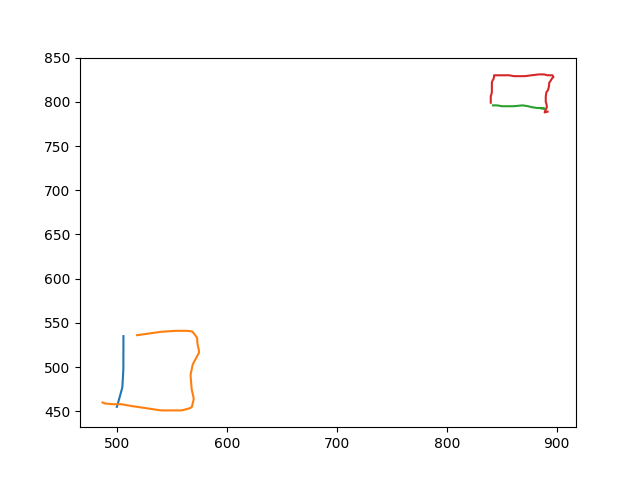

In [24]:
fig2, ax2 = plt.subplots()
org_sketch[a].visualize(show=False, ax=ax2)
tar_sketch[b].visualize(show=False, ax=ax2)

<IPython.core.display.Javascript object>


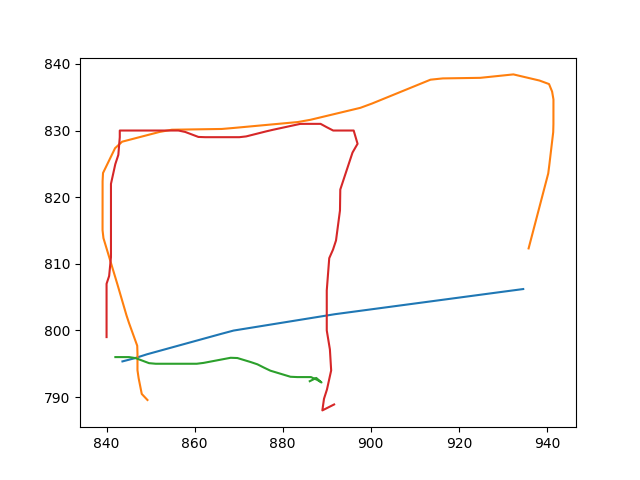

In [23]:
fig2, ax2 = plt.subplots()
org_obj.visualize(show=False, ax=ax2)
tar_obj.visualize(show=False, ax=ax2)

<IPython.core.display.Javascript object>


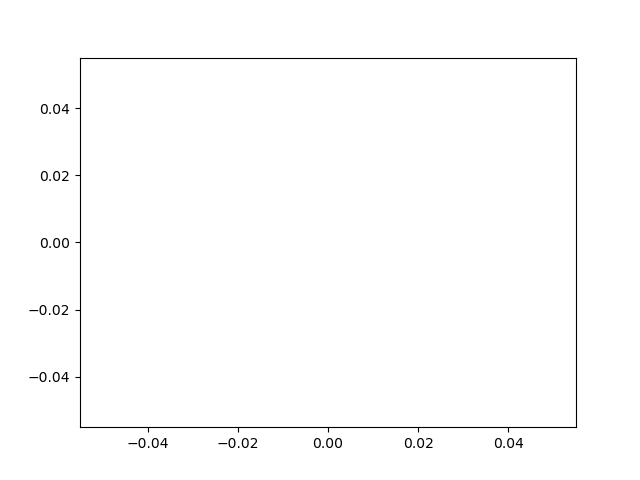

Before [0.10782389 1.48691726 1.97102165 0.81689262 0.0240031  2.61982036]


IndexError: index 6 is out of bounds for axis 0 with size 6

In [19]:
org_obj.reset()
obj1_seq = org_obj.get_copy()
animation = SketchAnimation([obj1_seq], [tar_obj]) 
animation.seq_animate_all([t], 
                         denormalize_trans=True,
                         save=False) 

<IPython.core.display.Javascript object>


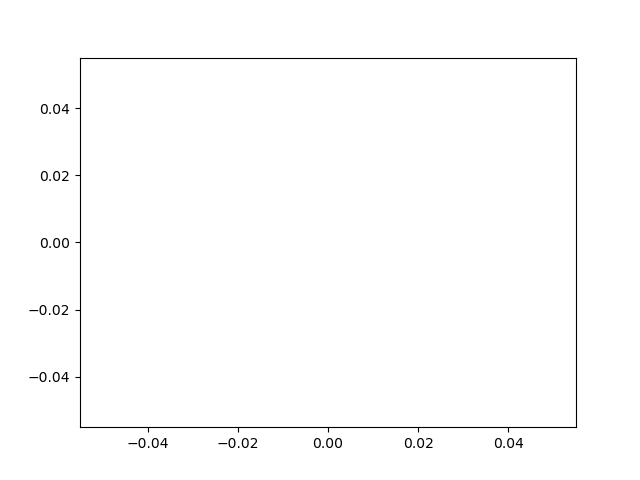

Before [[-8.93185198e-01 -8.25413048e-01 -3.25327277e+00 -1.57635808e-02
   1.08982608e-01  7.95383930e-01  9.21294594e+00]
 [-9.17694986e-01 -7.63193130e-01 -3.27688599e+00 -8.11071694e-03
   9.80733484e-02  8.26407492e-01  9.28569126e+00]
 [-8.95877779e-01 -8.19007576e-01 -3.25590014e+00 -1.49239451e-02
   1.08035326e-01  7.98214853e-01  9.22025204e+00]
 [-8.89989197e-01 -8.33318770e-01 -3.24994636e+00 -1.67022049e-02
   1.10478468e-01  7.91119993e-01  9.20243073e+00]
 [-8.86794031e-01 -8.41987312e-01 -3.24741530e+00 -1.78294033e-02
   1.11802243e-01  7.87410319e-01  9.19502544e+00]
 [-9.02433932e-01 -8.02103698e-01 -3.26210022e+00 -1.28517598e-02
   1.05045572e-01  8.06657434e-01  9.23956108e+00]
 [-8.93156588e-01 -8.25128853e-01 -3.25278044e+00 -1.56604499e-02
   1.09154664e-01  7.94887185e-01  9.21085644e+00]]


ValueError: setting an array element with a sequence.

In [87]:
c = 2
org_obj, tar_obj = org_sketch[c].get_copy(), tar_sketch[c].get_copy()
animation = SketchAnimation([org_obj], [tar_obj]) 
animation.seq_animate_all([trans_params[c]], 
                         denormalize_trans=True,
                         save=False) 

In [12]:
        
# fix and object in the target objects
cnt_ind = self.get_widest_obj_ind(tar_sketch)

# normalize all transformation according to the transformation of the fixed object
for i in range(len(final_params)):
    final_params[i][5] -= final_params[cnt_ind][5]
    final_params[i][6] -= final_params[cnt_ind][6]

if self.config.verbose > 3:
    model_visualizer.visualize_model(self.alignment_model, org_sketch, tar_sketch, org_sketch, tar_sketch, self.alignment_model.model_config)


if self.config.vis_video:
    # generate the video based on the final params
    anim = SketchAnimation(org_sketch, tar_sketch)
    anim.seq_animate_all(final_params, save=True, file=self.config.save_video_path, denormalize_trans=True)

NameError: name 'self' is not defined